# Conformal Prediction Portfolio Allocation
## Capstone Project: Backtesting Framework

This notebook provides a comprehensive analysis of classical vs. conformal prediction-aware portfolio allocation strategies.


## 1. Setup and Data Loading


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Import project modules
from data_loader import DataLoader
from models import XGBoostForecaster, MLPForecaster
from conformal import SplitConformalPredictor, evaluate_prediction_intervals
from allocation import create_all_allocators
from backtester import Backtester, PerformanceMetrics

print("Libraries imported successfully!")


Libraries imported successfully!


In [4]:
# Load data
loader = DataLoader(
    start_date='2015-01-01',
    end_date='2024-12-31',
    lookback=60
)

data = loader.load_data()

print(f"\nData loaded:")
print(f"  Period: {data['returns'].index[0]} to {data['returns'].index[-1]}")
print(f"  Assets: {len(loader.tickers)}")
print(f"  Trading days: {len(data['returns'])}")


Loading data for 11 tickers from 2015-01-01 to 2024-12-31...
Dropping tickers with >5% missing data: {'XLRE'}
Built 24 features per asset
Data loaded: 2515 days, 10 assets
Features shape: (24530, 26)

Data loaded:
  Period: 2015-01-02 00:00:00 to 2024-12-30 00:00:00
  Assets: 10
  Trading days: 2515


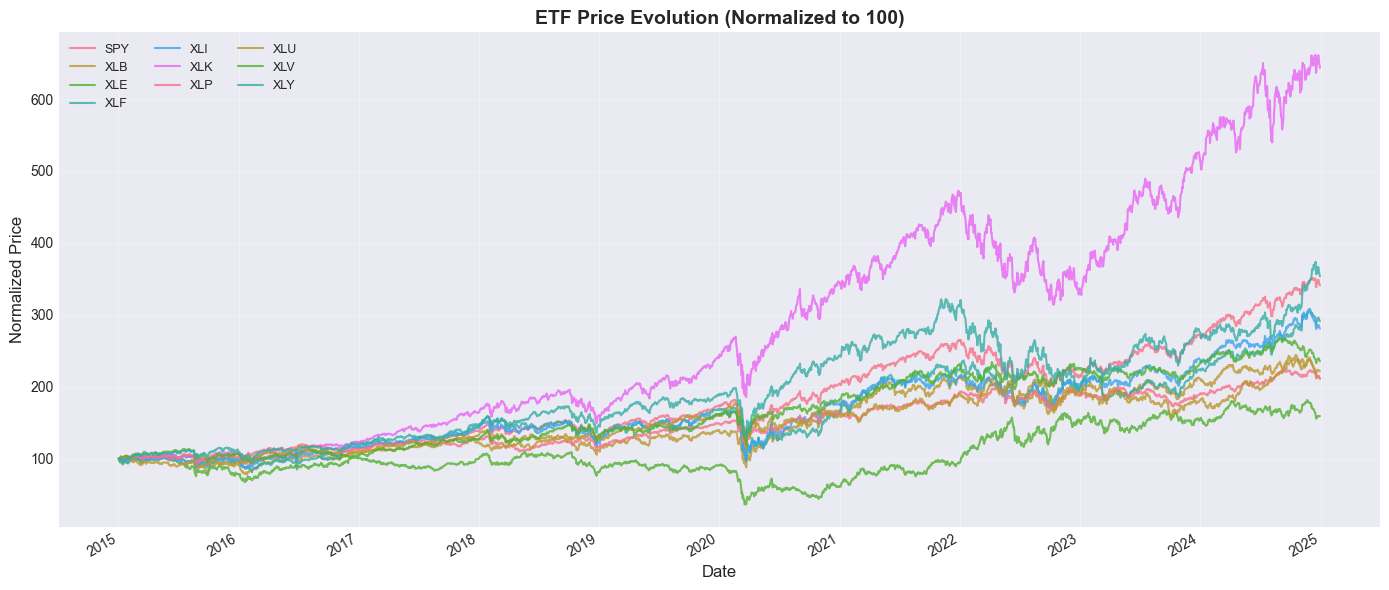

In [5]:
# Visualize price evolution
fig, ax = plt.subplots(figsize=(14, 6))

normalized_prices = data['prices'] / data['prices'].iloc[0] * 100
normalized_prices.plot(ax=ax, linewidth=1.5, alpha=0.8)

ax.set_title('ETF Price Evolution (Normalized to 100)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Normalized Price', fontsize=12)
ax.legend(loc='upper left', ncol=3, fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 2. Run Full Backtest

This section runs the complete backtesting pipeline comparing all strategies.


In [7]:
# Create allocators
allocators = create_all_allocators(
    vol_target=0.10,
    max_turnover=0.20
)

print("Allocation strategies:")
for name in allocators.keys():
    print(f"  - {name}")


Allocation strategies:
  - mean_variance
  - risk_parity
  - ml_only
  - cp_gate
  - cp_size
  - cp_lower_bound


In [8]:
# Initialize backtester
backtester = Backtester(
    data_loader=loader,
    train_window=252,
    cal_window=126,
    rebalance_freq=5,  # Rebalance weekly
    transaction_cost=0.001,  # 10 bps
    regime_detection=True
)

# Run backtest (this may take several minutes)
print("\nRunning backtest...")
print("This may take 5-10 minutes depending on your hardware.\n")

results = backtester.run_all_strategies(
    model_class=XGBoostForecaster,
    allocators=allocators,
    test_start_date='2020-01-01',
    alpha=0.1
)

print("\n" + "="*50)
print("Backtest completed!")
print("="*50)



Running backtest...
This may take 5-10 minutes depending on your hardware.


Backtesting mean_variance...


mean_variance: 100%|██████████████████████████| 252/252 [00:28<00:00,  8.94it/s]



Backtesting risk_parity...


risk_parity: 100%|████████████████████████████| 252/252 [00:23<00:00, 10.58it/s]



Backtesting ml_only...


ml_only: 100%|████████████████████████████████| 252/252 [00:23<00:00, 10.73it/s]



Backtesting cp_gate...


cp_gate: 100%|████████████████████████████████| 252/252 [00:23<00:00, 10.80it/s]



Backtesting cp_size...


cp_size: 100%|████████████████████████████████| 252/252 [00:24<00:00, 10.29it/s]



Backtesting cp_lower_bound...


cp_lower_bound: 100%|█████████████████████████| 252/252 [00:28<00:00,  8.99it/s]


Backtest completed!


## 3. Performance Analysis


In [10]:
# Performance table
perf_table = backtester.get_performance_table()

# Format for display
display_cols = ['ann_return', 'ann_vol', 'sharpe', 'sortino', 'max_drawdown', 'calmar', 'avg_turnover']
perf_display = perf_table[display_cols].copy()

# Format as percentages
perf_display['ann_return'] = perf_display['ann_return'] * 100
perf_display['ann_vol'] = perf_display['ann_vol'] * 100
perf_display['max_drawdown'] = perf_display['max_drawdown'] * 100
perf_display['avg_turnover'] = perf_display['avg_turnover'] * 100

# Rename columns
perf_display.columns = ['Ann. Return (%)', 'Ann. Vol (%)', 'Sharpe', 'Sortino', 
                        'Max DD (%)', 'Calmar', 'Avg Turnover (%)']

print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(perf_display.round(2))
print("="*80)



PERFORMANCE SUMMARY
                Ann. Return (%)  Ann. Vol (%)  Sharpe  Sortino  Max DD (%)  \
mean_variance             16.25         18.37    0.88     1.37       -8.29   
risk_parity               29.33         20.81    1.41     2.09       -8.08   
ml_only                   27.76         22.60    1.23     1.91       -8.46   
cp_gate                   31.88         21.77    1.46     2.18       -8.29   
cp_size                   27.76         22.60    1.23     1.91       -8.46   
cp_lower_bound            17.48         18.84    0.93     1.46       -7.88   

                Calmar  Avg Turnover (%)  
mean_variance     1.96             17.75  
risk_parity       3.63              3.52  
ml_only           3.28             19.72  
cp_gate           3.85              0.46  
cp_size           3.28             19.72  
cp_lower_bound    2.22             18.78  


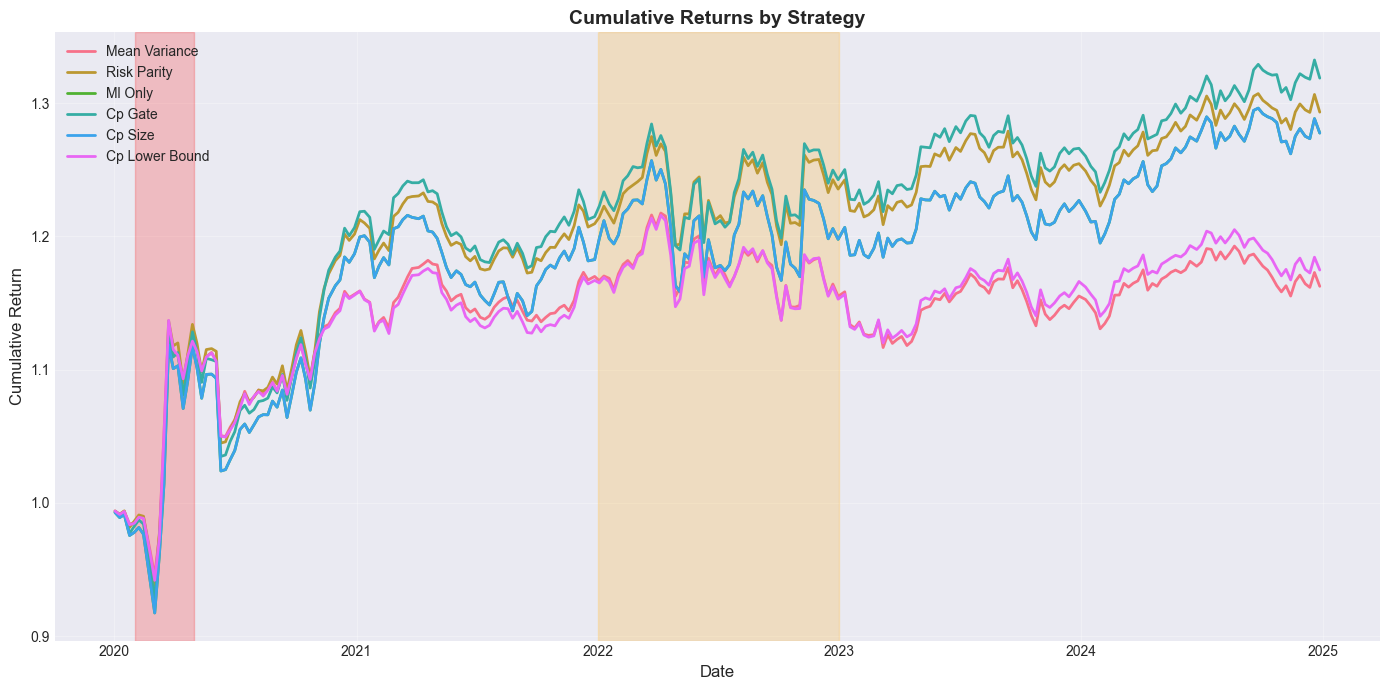

In [11]:
# Equity curves
fig, ax = plt.subplots(figsize=(14, 7))

for strategy_name, result in results.items():
    cumulative_returns = (1 + result['returns']).cumprod()
    ax.plot(cumulative_returns.index, cumulative_returns.values, 
            label=strategy_name.replace('_', ' ').title(), linewidth=2)

ax.set_title('Cumulative Returns by Strategy', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Cumulative Return', fontsize=12)
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)

# Highlight stress periods
ax.axvspan('2020-02-01', '2020-04-30', alpha=0.2, color='red')
ax.axvspan('2022-01-01', '2022-12-31', alpha=0.2, color='orange')

plt.tight_layout()
plt.show()


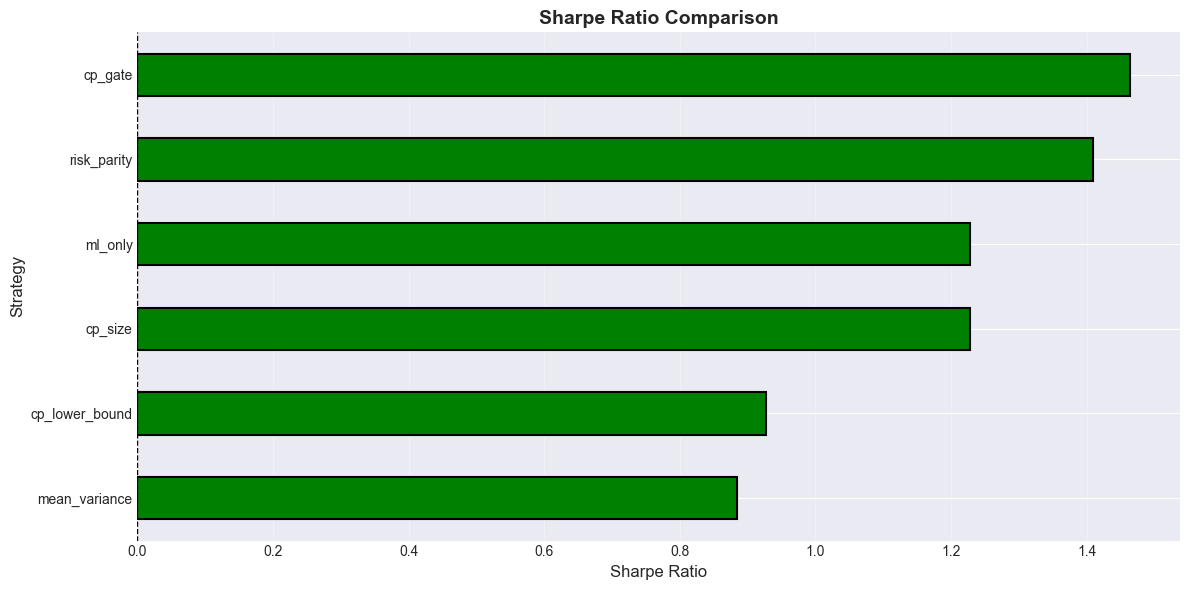

In [12]:
# Sharpe ratio comparison
fig, ax = plt.subplots(figsize=(12, 6))

sharpe_ratios = perf_table['sharpe'].sort_values(ascending=True)
colors = ['red' if x < 0 else 'green' for x in sharpe_ratios.values]

sharpe_ratios.plot(kind='barh', ax=ax, color=colors, edgecolor='black', linewidth=1.5)

ax.set_title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Sharpe Ratio', fontsize=12)
ax.set_ylabel('Strategy', fontsize=12)
ax.axvline(0, color='black', linewidth=1, linestyle='--')
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## 4. Stress Testing


In [14]:
# COVID crash stress test
covid_stress = backtester.stress_test(
    start_date='2020-02-01',
    end_date='2020-04-30',
    period_name='COVID Crash'
)

print("\nCOVID Crash (Feb-Apr 2020) Performance:")
print("="*80)
print(covid_stress[['ann_return', 'ann_vol', 'sharpe', 'max_drawdown']].round(3))
print("="*80)



COVID Crash (Feb-Apr 2020) Performance:
                ann_return  ann_vol  sharpe  max_drawdown
mean_variance       14.307    0.559  25.584        -0.045
risk_parity         17.778    0.609  29.213        -0.053
ml_only             15.561    0.646  24.075        -0.065
cp_gate             17.346    0.628  27.632        -0.060
cp_size             15.561    0.646  24.075        -0.065
cp_lower_bound      14.349    0.581  24.688        -0.048


In [15]:
# 2022 inflation stress test
inflation_stress = backtester.stress_test(
    start_date='2022-01-01',
    end_date='2022-12-31',
    period_name='2022 Inflation'
)

print("\n2022 Inflation Regime Performance:")
print("="*80)
print(inflation_stress[['ann_return', 'ann_vol', 'sharpe', 'max_drawdown']].round(3))
print("="*80)



2022 Inflation Regime Performance:
                ann_return  ann_vol  sharpe  max_drawdown
mean_variance       -0.061    0.194  -0.316        -0.066
risk_parity          0.111    0.223   0.499        -0.064
ml_only              0.065    0.255   0.256        -0.078
cp_gate              0.118    0.234   0.505        -0.074
cp_size              0.065    0.255   0.256        -0.078
cp_lower_bound      -0.058    0.201  -0.289        -0.065
